In [33]:
import addfips
import requests
import matplotlib.pyplot as plt
from IPython.display import Image
import folium
import pickle
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
import pyproj
import collections

%matplotlib inline

#### Bring in the counties shapefile

In [34]:
counties = gpd.read_file('../data/counties/tncounty.shp')
print(counties.crs)
counties.head()

epsg:2274


,OBJECTID,NAME,KEY,SHAPE_AREA,SHAPE_LEN,geometry
0,76,Chester,47023,8.049024e+09,520461.080124,"POLYGON ((1137985.762 344601.643, 1137965.070 ..."
1,77,Wayne,47181,2.050741e+10,666520.678598,"POLYGON ((1365052.057 391716.806, 1365746.554 ..."
2,78,Tipton,47167,1.319125e+10,865093.887634,"MULTIPOLYGON (((886814.330 400456.525, 886774...."
3,79,Hamilton,47065,1.604776e+10,652926.001078,"POLYGON ((2274954.438 239788.911, 2274090.610 ..."
4,80,Stewart,47161,1.375003e+10,490090.336180,"POLYGON ((1382472.783 743972.302, 1382445.171 ..."


In [35]:
counties.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Tennessee
- bounds: (-90.31, 34.98, -81.65, 36.68)
Coordinate Operation:
- name: SPCS83 Tennessee zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

##### I know the other shapefiles I have have NAD83 datum... we'll see how they all go together

#### Bring in the county level species data

In [36]:
spec = pd.read_csv('../data/rare_species_by_county.csv')

In [37]:
spec.head()

,County,Type,Category,Scientific Name,Common Name,Global Rank,State Rank,Fed. Status,State Status,Habitat,Wet Habitat Flag
0,Anderson,Invertebrate Animal,Arachnid,Hesperochernes mirabilis,Southeastern Cave Pseudoscorpion,G5,S3,--,"Rare, Not State Listed",Terrestrial cave obligate; woodrat debris in c...,Upland
1,Anderson,Invertebrate Animal,Mollusc,Cyprogenia stegaria,Fanshell,G1,S1,"LE, XN",E,Medium to large streams and rivers with coarse...,Aquatic
2,Anderson,Vertebrate Animal,Bird,Limnothlypis swainsonii,Swainson's Warbler,G4,S3,--,D,"Mature, rich, damp, deciduous floodplain and s...",Possible
3,Anderson,Vertebrate Animal,Reptile,Ophisaurus attenuatus longicaudus,Eastern Slender Glass Lizard,G5T5,S3,--,D,"Dry upland areas including brushy, cut-over wo...",Upland
4,Anderson,Vertebrate Animal,Bird,Vermivora chrysoptera,Golden-winged Warbler,G4,S3B,--,T,Early successional habitats in foothill region...,Upland


##### Rename columns with no spaces, create a column that makes it easy to sum instances, "summer" and group by County

In [38]:
spec.columns = ['County', 'Type', 'Category', 'Scientific_Name', 'Common_Name', 
               'Global_Rank', 'State_Rank', 'Fed_Status', 'State_Status', 'Habitat', 'Wet_Habitat_Flag']

In [41]:
species_list = spec['Common_Name'].value_counts()

In [7]:
spec['summer'] = 1

In [8]:
allspec_bycounty = spec.groupby(['County']).agg({'summer': sum})

##### Join the geometry from original counties file

#### How many of each of the ranks are we seeing in the whole state?

First, global rank:

In [9]:
spec.Global_Rank

0          G5
1          G1
2          G4
3        G5T5
4          G4
        ...  
4422      G3Q
4423       G5
4424    G5T4?
4425       G5
4426       G1
Name: Global_Rank, Length: 4427, dtype: object

In [10]:
gtype_list = spec.Global_Rank.tolist()

In [11]:
type(gtype_list)

list

In [12]:
collections.Counter(gtype_list)

Counter({'G5': 1098,
         'G1': 433,
         'G4': 602,
         'G5T5': 56,
         'G1G2': 133,
         'G3': 697,
         'G3G4': 297,
         'GNR': 71,
         'G2G3': 253,
         'G4T4': 34,
         'G3G5': 17,
         'G4?T4Q': 11,
         'G2': 267,
         'G3?': 22,
         'G4G5': 138,
         'G3G4T3': 14,
         'G2?': 18,
         'G2Q': 15,
         'G3QT3Q': 17,
         'G5T3Q': 13,
         'G5T4?': 8,
         'G4?': 41,
         'G5T4Q': 5,
         'G5?': 24,
         'G1G2Q': 8,
         'GNRT1': 1,
         'G5T2': 8,
         'G3T2T3': 4,
         'G5T3?': 5,
         'G2G4': 10,
         'G3Q': 8,
         'G1Q': 11,
         'G4G5T4T5': 7,
         'GH': 3,
         'G5T4T5': 5,
         'G3G4T2': 4,
         'G5T3': 4,
         'G4?Q': 7,
         'GU': 2,
         'G4G5T4': 3,
         'G5?T3': 3,
         'G4T2': 3,
         'G2G3Q': 8,
         'G4G5T4?': 7,
         'G4G5T3': 4,
         'G4T3Q': 5,
         'G5T3T5': 1,
         'G3G4

In [13]:
gtype_dict = collections.Counter(gtype_list)

In [14]:
gtype_df = pd.DataFrame.from_dict(gtype_dict, orient = 'index', columns = ['count'])

In [22]:
gtype_df = gtype_df.sort_values(['count']).reset_index()

In [23]:
gtype_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   58 non-null     object
 1   count   58 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


(array([   0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

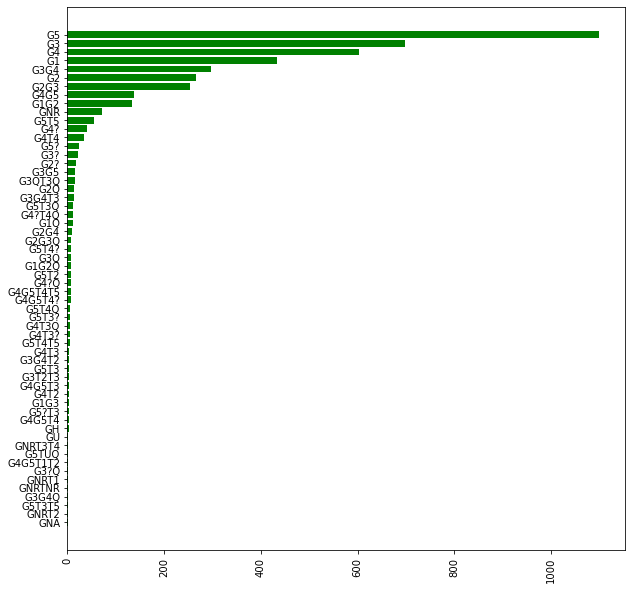

In [28]:
#plot:

plt.figure(figsize = (10, 10))
plt.barh(y = 'index', width = 'count', data = gtype_df, color = 'green')
plt.xticks(rotation = 90)

In [ ]:
fig, ax = plt.subplots()
ax.plot

Next, State rank:

In [20]:
stype_list = spec.State_Rank.tolist()

In [21]:
stype_dict = collections.Counter(stype_list)

In [22]:
stype_df = pd.DataFrame.from_dict(stype_dict, orient = 'index', columns = ['count'])

In [23]:
stype_df.sort_values(['count']).reset_index(inplace = False)

,index,count
0,S1S3,1
1,SX,1
2,SU,1
3,"S1B,S4N",3
4,S2S4,3
5,"S1B,S2N",4
6,S3?,5
7,S2S3B,5
8,"S2B,S3N",5
9,S1?,15


<AxesSubplot:title={'center':'State Species Status and Ranks in Tennessee'}, xlabel='Species Status and Rank', ylabel='Reports'>

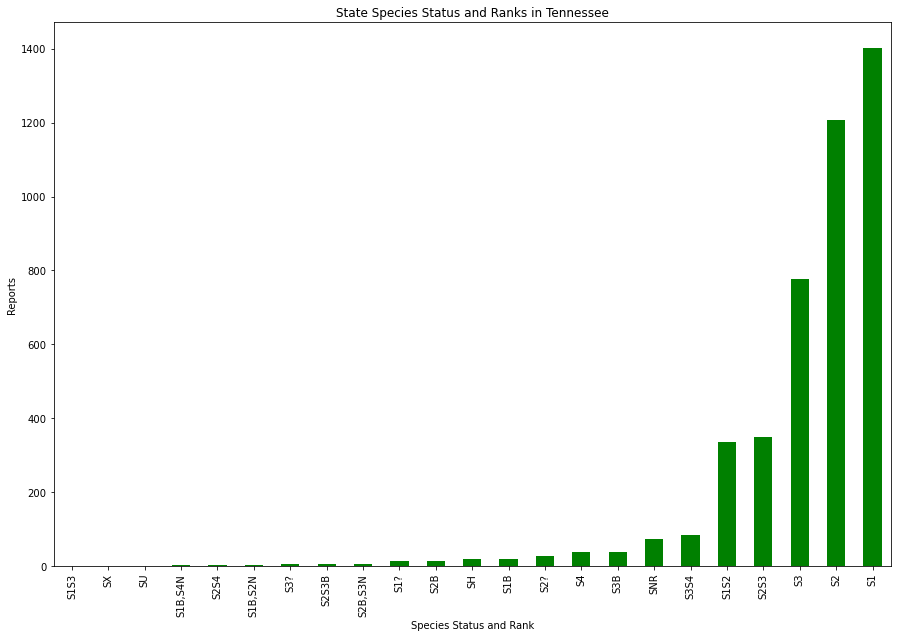

In [24]:
stype_df.sort_values(['count']).plot(kind = 'bar', 
                                          figsize = (15, 10), 
                                          title = 'State Species Status and Ranks in Tennessee', 
                                          color = 'green',
                                          xlabel = 'Species Status and Rank', 
                                          ylabel = 'Reports', 
                                          legend = False)

Same process but with Federal Status:

In [25]:
fstat_list = spec.Fed_Status.tolist()

In [26]:
fstat_dict = collections.Counter(fstat_list)

In [27]:
fstat_df = pd.DataFrame.from_dict(fstat_dict, orient = 'index', columns = ['count'])

In [28]:
fstat_df.sort_values(['count']).reset_index(inplace = False)

,index,count
0,SC,1
1,SAT,2
2,C,4
3,"LT, XN",6
4,"LT,XN",20
5,"LE,XN",20
6,DM,21
7,No Status,48
8,LT,113
9,"LE, XN",170


<AxesSubplot:title={'center':'Federal Status of Species in Tennessee'}, xlabel='Species Status', ylabel='Reports'>

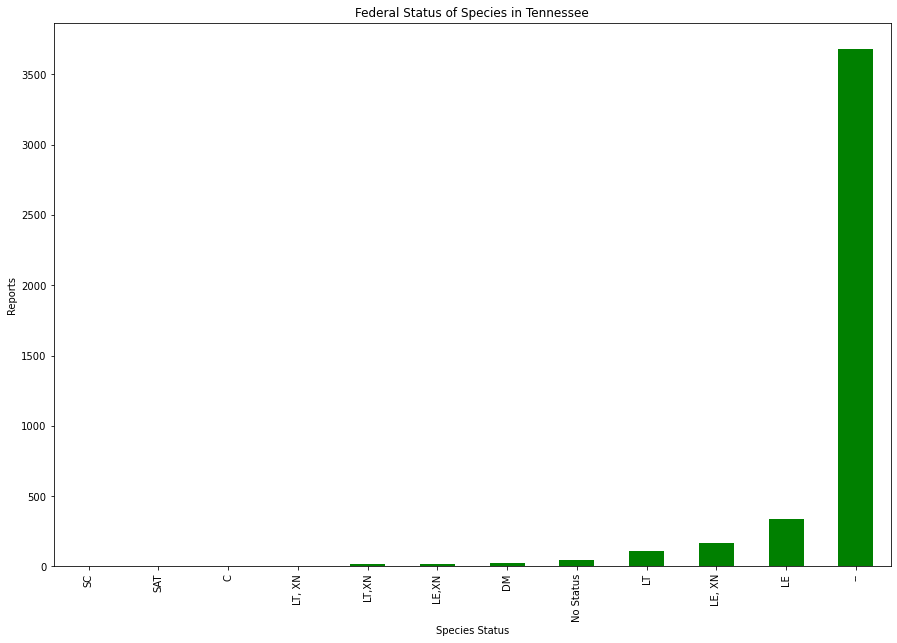

In [29]:
fstat_df.sort_values(['count']).plot(kind = 'bar', 
                                          figsize = (15, 10), 
                                          title = 'Federal Status of Species in Tennessee', 
                                          color = 'green',
                                          xlabel = 'Species Status', 
                                          ylabel = 'Reports', 
                                          legend = False)

Next: Type

In [51]:
type_list = spec.Type.tolist()

In [52]:
type_dict = collections.Counter(type_list)

In [53]:
type_df = pd.DataFrame.from_dict(type_dict, orient = 'index', columns = ['count'])

In [54]:
type_df.sort_values(['count']).reset_index(inplace = False)

,index,count
0,Fungus,4
1,International Terrestrial Ecological System Cl...,31
2,Animal Assemblage,42
3,International Vegetation Classification - Natural,43
4,Nonvascular Plant,121
5,Invertebrate Animal,984
6,Vertebrate Animal,1241
7,Vascular Plant,1961


<AxesSubplot:title={'center':'Type Classifications of Species in Tennessee'}, xlabel='Species Type', ylabel='Reports'>

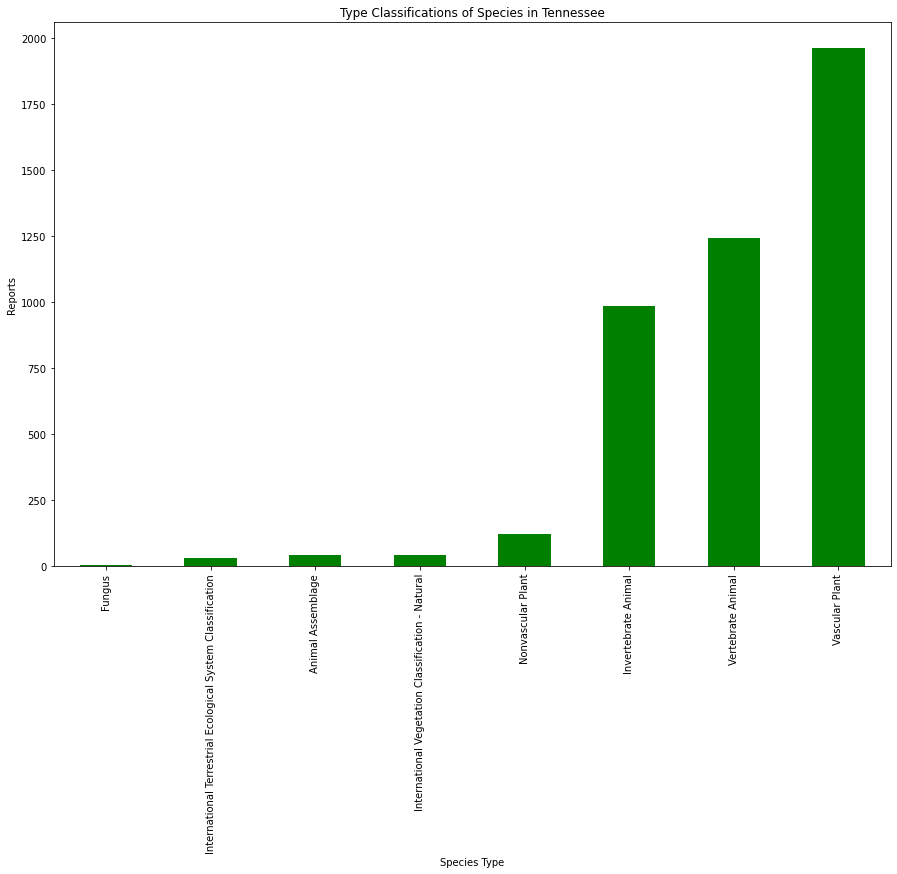

In [57]:
type_df.sort_values(['count']).plot(kind = 'bar', 
                                          figsize = (15, 10), 
                                          title = 'Type Classifications of Species in Tennessee', 
                                          color = 'green',
                                          xlabel = 'Species Type', 
                                          ylabel = 'Reports', 
                                          legend = False)

Now with Category:

In [40]:
cat_list = spec.Category.tolist()

In [41]:
cat_dict = collections.Counter(cat_list)

In [42]:
cat_df = pd.DataFrame.from_dict(cat_dict, orient = 'index', columns = ['count'])

In [43]:
cat_df.sort_values(['count']).reset_index(inplace = False)

,index,count
0,Planarian,2
1,Tardigrade,2
2,Annelid,4
3,Liverwort,4
4,Plant: Gymnosperm,13
5,Other Type,20
6,No Data,42
7,Arachnid,61
8,Plant Community,74
9,Fern and Fern Ally,74


<AxesSubplot:title={'center':'Categories of Species in Tennessee'}, xlabel='Species Category', ylabel='Reports'>

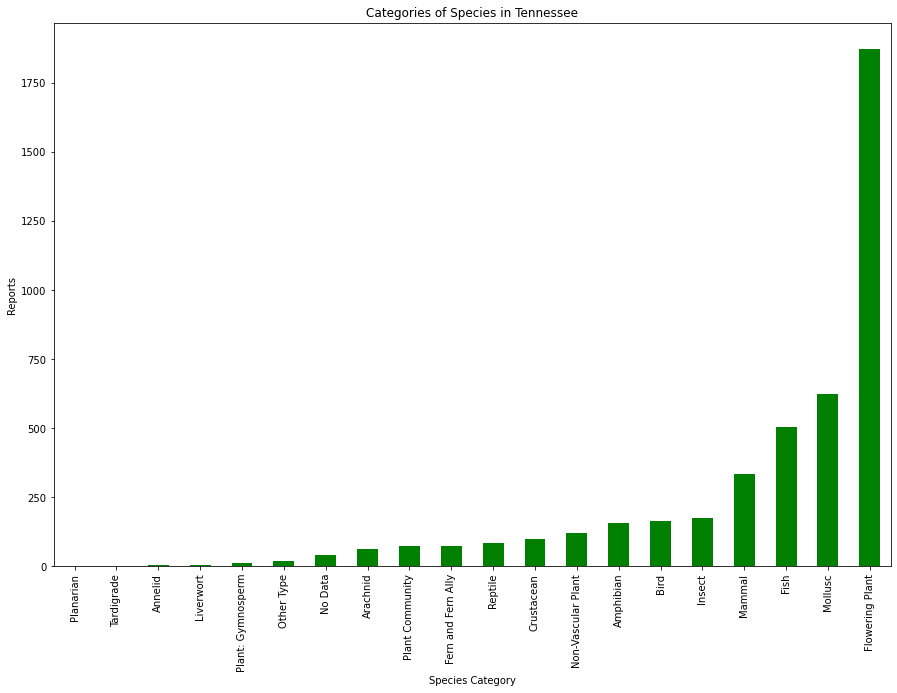

In [45]:
cat_df.sort_values(['count']).plot(kind = 'bar', 
                                          figsize = (15, 10), 
                                          title = 'Categories of Species in Tennessee', 
                                          color = 'green',
                                          xlabel = 'Species Category', 
                                          ylabel = 'Reports', 
                                          legend = False)